In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
plt.style.use('seaborn-deep')
plt.style.use("seaborn-darkgrid")

from sklearn.preprocessing import MinMaxScaler
import math
from scipy import stats

In [2]:
df = pd.read_csv('../data/train.csv')
df.drop('id', axis=1, inplace=True)
new_columns = ['weight', 'quality', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z', 'price']
df.columns = new_columns
df['depth'] = df['depth'] / 100
df['depth_percent'] = 2 * df['z'] / (df['x'] + df['y']) #total depth percentage = z / mean(x, y) = 2 * z / (x + y)
df['diff_depth_abs'] = abs(df['depth'] - df['depth_percent']) #abs difference between depth and depth percentage
df['diff_depth_perc'] = (abs(df['depth'] - df['depth_percent']) / df['depth']) * 100 #percentage difference between depth and depth percentage
df.drop(df.loc[df['x'] == 0].index, inplace=True) #drop rows with x = 0
df.drop(df.loc[df['y'] == 0].index, inplace=True) #drop rows with y = 0
df.drop(df.loc[df['z'] == 0].index, inplace=True) #drop rows with z = 0
df.drop(df.loc[df['diff_depth_perc'] > 1].index, inplace=True) #drop 91 rows difference > 1%
df.drop(['depth', 'x', 'y', 'z', 'diff_depth_abs', 'diff_depth_perc'], axis=1, inplace=True) #drop depth, x, y, z, diff_depth_abs, diff_depth_perc
df.drop_duplicates(inplace=True) #113 duplicated rows
print(df.shape)
df.sample(5)

(40233, 7)


,weight,quality,color,clarity,table,price,depth_percent
30697,1.50,Good,H,VS1,56.0,9.077,0.642113
27616,0.33,Very Good,G,VVS1,57.0,6.678,0.613122
22095,0.41,Very Good,I,VVS2,57.0,6.931,0.599182
10770,0.38,Ideal,E,VS1,53.0,6.808,0.617021
15407,1.51,Very Good,H,VS1,59.0,9.320,0.618232


In [3]:
#split categorical and numerical variables
col_num = df.select_dtypes(include = np.number).columns
col_cat = df.select_dtypes(include = 'object').columns
print(col_num)
print(col_cat)

Index(['weight', 'table', 'price', 'depth_percent'], dtype='object')
Index(['quality', 'color', 'clarity'], dtype='object')


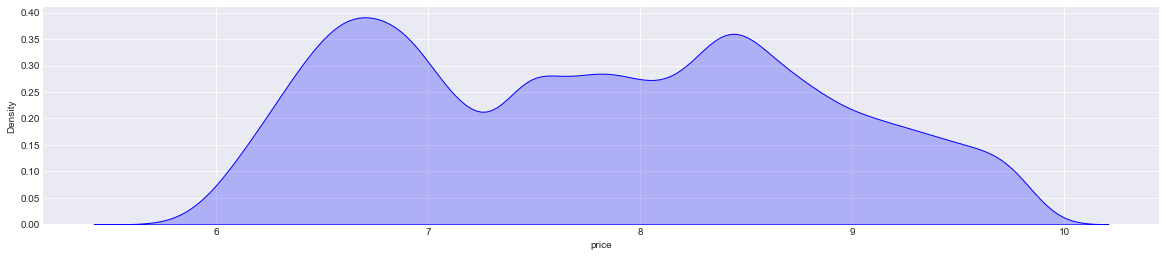

In [4]:
#plot response variable distribution
fig, axes = plt.subplots(figsize = (20, 4))
sns.distplot(df.price, hist = False, color = "blue", kde_kws = {"shade": True, "linewidth": 1});

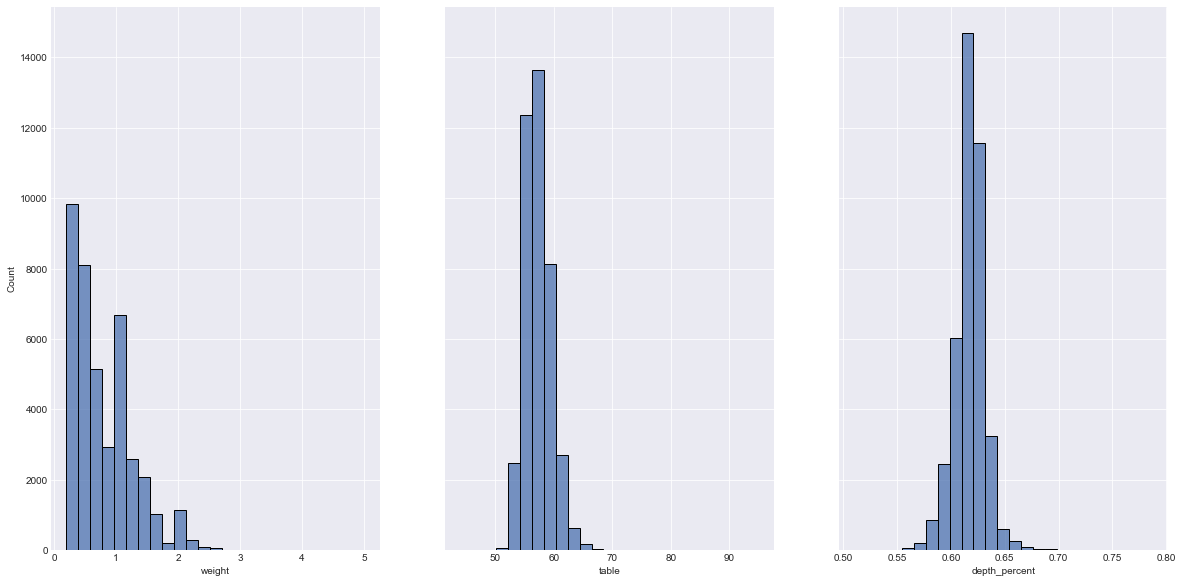

In [5]:
#plot numerical variables distribution
fig, ax = plt.subplots(1, 3, figsize = (20,10), sharey=True)
ax = ax.flat
df_num = df[col_num.drop('price')]
counter = 0
for i in df_num.columns:
    sns.histplot(df_num[i], kde = False, ax = ax[counter], bins=25)
    counter += 1
plt.show();

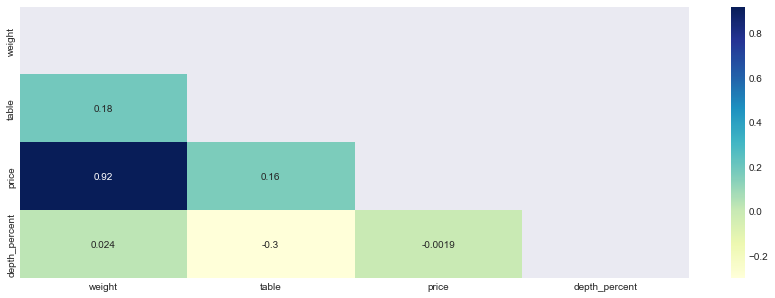

In [6]:
#headmap corr plot
fig, axes = plt.subplots(figsize = (15, 5))
mask = np.triu(np.ones_like(df[col_num].corr(), dtype = np.bool))
sns.heatmap(df[col_num].corr(), 
           cmap = "YlGnBu", 
            mask = mask,
           annot = True);

price vs depth_percent have no correlation


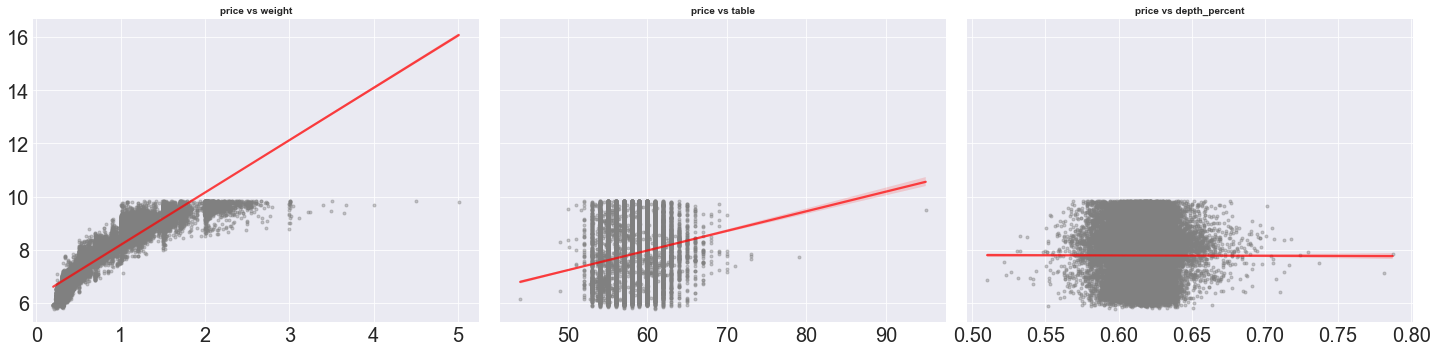

In [7]:
#plotteamos correlaciones entre variables predictoras y respuesta
fig, axes = plt.subplots(1, 3, figsize = (20,5), sharey=True)
axes = axes.flat
for i, colum in enumerate(df_num.columns):
    sns.regplot(
        x = df[colum], 
        y = df["price"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"price vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.tight_layout();
print('price vs depth_percent have no correlation')

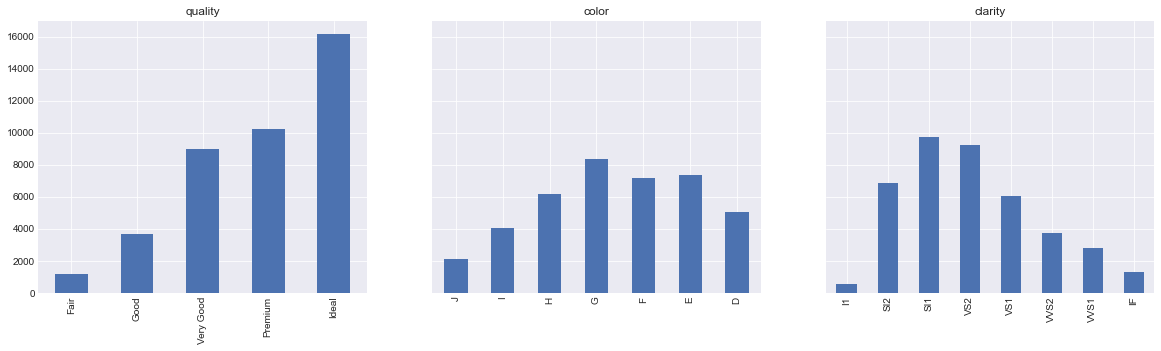

In [8]:
#plot categorical variables distribution
mapping = {'quality':['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], 
            'color':['J', 'I', 'H', 'G', 'F', 'E', 'D'],
            'clarity':['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']}
fig, ax = plt.subplots(1, 3, figsize = (20,5), sharey=True)
ax = ax.flat
counter = 0
for i in df[col_cat].columns:
    df[i].value_counts().loc[mapping[i]].plot.bar(ax=ax[counter]).set_title(i)
    counter += 1
plt.show();    

In [9]:
#encoding categorical variables
mapping = {'quality':['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], 
            'color':['J', 'I', 'H', 'G', 'F', 'E', 'D'],
            'clarity':['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']}
for k,v in mapping.items():
    for i in v:
        df[k] = df[k].replace(i, v.index(i))

In [10]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
weight,40233.0,0.796799,0.474909,0.200000,0.400000,0.700000,1.040000,5.010000
quality,40233.0,2.908011,1.115882,0.000000,2.000000,3.000000,4.000000,4.000000
color,40233.0,3.409067,1.703616,0.000000,2.000000,3.000000,5.000000,6.000000
clarity,40233.0,3.050630,1.646715,0.000000,2.000000,3.000000,4.000000,7.000000
table,40233.0,57.450093,2.231361,44.000000,56.000000,57.000000,59.000000,95.000000
price,40233.0,7.783046,1.016340,5.787000,6.851000,7.779000,8.579000,9.842000
depth_percent,40233.0,0.617472,0.014265,0.510226,0.610413,0.618364,0.625239,0.787295


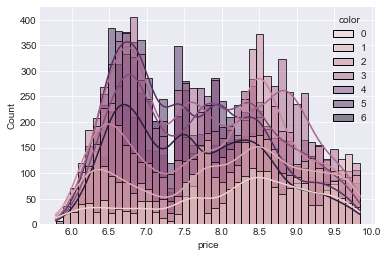

In [11]:
sns.histplot(data = df, x = df['price'], hue = "color", kde=True);

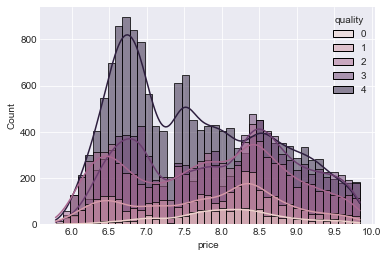

In [12]:
sns.histplot(data = df, x = df['price'], hue = "quality", kde=True);

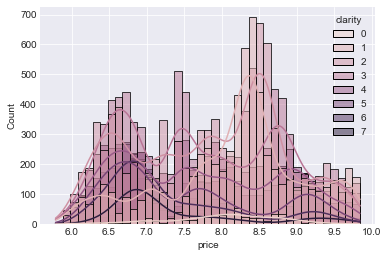

In [13]:
sns.histplot(data = df, x = df['price'], hue = "clarity", kde=True);

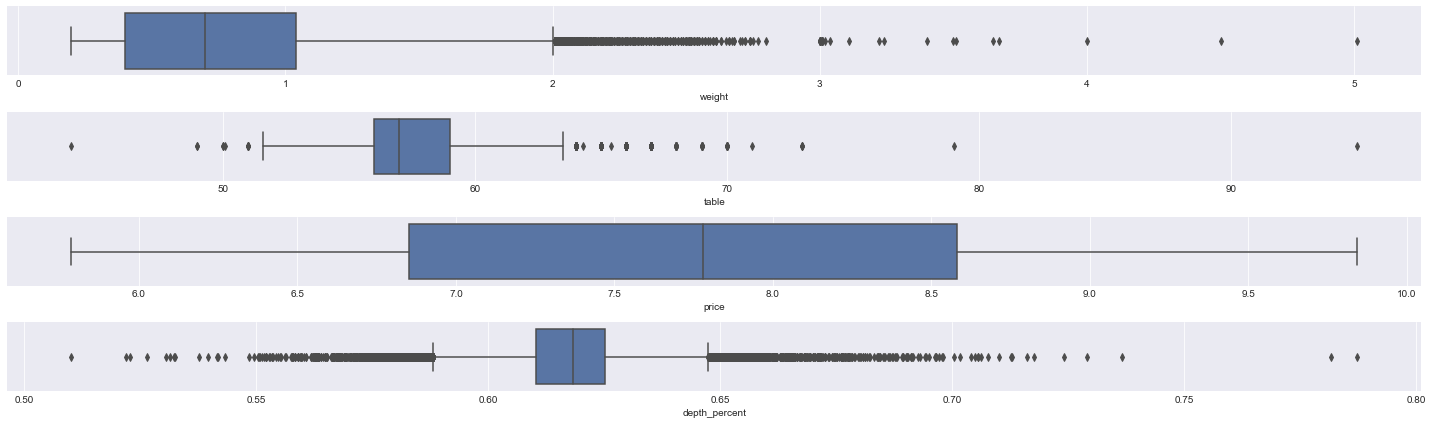

In [19]:
#plot outliers
fig, axes = plt.subplots(4, 1, figsize=(20,6))

for i in range(len(col_num)):
    sns.boxplot(x=df[col_num].columns[i], data=df[col_num], ax=axes[i])
    plt.tight_layout()
plt.show();

In [21]:
#get outliers
def find_outliers(columns, dataframe): 
    dicc_indexes = {}
    for col in columns:
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        if outliers_data.shape[0] > 0:
            dicc_indexes[col] = (list(outliers_data.index))    
    return dicc_indexes

outliers = find_outliers(col_num, df)
outliers_list = []
for k, v in outliers.items():
    print('Column: ', k, '\n', 'Outliers: ', len(v))
    for i in v:
        outliers_list.append(i)
outliers_list = set(outliers_list)
outliers_list = list(outliers_list)
len(outliers_list)

Column:  weight 
 Outliers:  1426
Column:  table 
 Outliers:  442
Column:  depth_percent 
 Outliers:  2009


3552